- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Training only, EDA part not included.
- Image model only, tabular data not used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os

tqdm.pandas()

In [2]:
class Config():
    IMAGE_SIZE = 224#384
    BACKBONE = 'vit_base_patch16_clip_224.openai_ft_in12k'#'efficientnet_b0' #'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 6
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    BUILD_PKL_DATASET = False
    BUILD_VALID_SET = False
    USE_SMALL_DATASET = False
    USE_VALID_SET = False
    USE_MODIFIED_TRAIN = False
    USE_XGBOOST = False
    USE_PREPROCESSING = False
        
CONFIG = Config()

In [3]:
if CONFIG.BUILD_PKL_DATASET is True:
    train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
    train['file_path'] = train['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
    train['jpeg_bytes'] = train['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    train.to_pickle('train.pkl')
    test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
    test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
    test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    test.to_pickle('test.pkl')
else:
    if CONFIG.USE_SMALL_DATASET is True:
        train = pd.read_pickle('/kaggle/input/dataset-with-validation/small_train.pkl')       
    elif CONFIG.USE_MODIFIED_TRAIN is True:
        train = pd.read_pickle('/kaggle/input/dataset-with-validation/train_set.pkl')
    else:
         train = pd.read_pickle('/kaggle/input/baseline-model/train.pkl')
    test = pd.read_pickle('/kaggle/input/baseline-model/test.pkl')
    
for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(0.005)
    upper_quantile = train[column].quantile(0.985)  
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

N_TRAIN_SAMPLES: 49168 N_TEST_SAMPLES: 6545


In [4]:
#all columns must be identical to be consider the same species
trait_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
train['species'] = train.groupby(CONFIG.TARGET_COLUMNS).ngroup()
species_counts = train['species'].nunique()
print (f"{species_counts} unique species found in {len(train)} records")

17535 unique species found in 49168 records


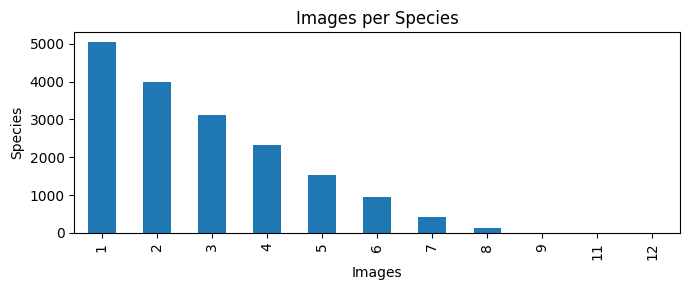

In [5]:
species_counts = train['species'].value_counts()
count_summary = species_counts.value_counts().sort_index()
count_summary.plot(kind='bar', figsize=(7, 3))

plt.title('Images per Species')
plt.xlabel('Images')
plt.ylabel('Species')
plt.tight_layout() 
plt.show()

## Preprocessing

In the nature article, the authors performed data notmalisation in all the columns. In their case they had less auxilary data. Here, we will preprocess all the data.

Details for all these can be foud at https://www.kaggle.com/code/vaggelisspi/planttraits-working-through-the-nature-article#Pre-processing.

In [6]:
if CONFIG.USE_PREPROCESSING is True:
    # not worring about '_sd' columns for now
    sd_columns = [col for col in train.columns if col.endswith('_sd')]
    train = train.drop(columns=sd_columns)
    # the columns of the auxilary data
    PREPROCESS_COLS = test.columns[1:-2].tolist()
    # preprocess the data
    norm_data = np.zeros_like(train[PREPROCESS_COLS], dtype=np.float32)
    for col_idx, col in enumerate(PREPROCESS_COLS):
        v = train[col].values
        v = np.log10(v)
        norm_data[:, col_idx] = v
    # 
    norm_data[norm_data == np.inf] = 0
    norm_data[norm_data == -np.inf] = 0
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(norm_data)

    for col_idx, col in enumerate(PREPROCESS_COLS):
        v = norm_data[:, col_idx]
        train[col] = v

    train = train.fillna(0)
    print(train.head())
    print(train.isnull().sum().sum())
    
    # preprocess the test data
    norm_data = np.zeros_like(test[PREPROCESS_COLS], dtype=np.float32)
    for col_idx, col in enumerate(PREPROCESS_COLS):
        v = test[col].values
        v = np.log10(v)
        norm_data[:, col_idx] = v

    norm_data[norm_data == np.inf] = 0
    norm_data[norm_data == -np.inf] = 0
    # scaler = StandardScaler()
    norm_data = scaler.fit_transform(norm_data)

    for col_idx, col in enumerate(PREPROCESS_COLS):
        v = norm_data[:, col_idx]
        test[col] = v

    print(test.head())
    print(test.isnull().sum().sum())

In [7]:
if CONFIG.BUILD_VALID_SET is True:
    unique_species = train['species'].unique()
    n_test_species_exclusive = 2

    # Randomly pick exclusive test species
    test_species_exclusive = np.random.choice(unique_species, n_test_species_exclusive, replace=False)

    # Isolate exclusive test species data
    exclusive_test_set = train[train['species'].isin(test_species_exclusive)]

    # Remove exclusive test species from main data
    train_reduced = train[~train['species'].isin(test_species_exclusive)]
    print(len(train_reduced))
    test_set_common = pd.DataFrame()
    for species in train_reduced['species'].unique():
        species_data = train_reduced[train_reduced['species'] == species]
        sample = species_data.sample(1, random_state=42) 
        test_set_common = pd.concat([test_set_common, sample])

    # Remove these samples from train
    train_set = train_reduced.drop(test_set_common.index)

    valid_set = pd.concat([exclusive_test_set, test_set_common])
#     train_set.to_pickle('train_set.pkl')
#     valid_set.to_pickle('valid_set.pkl')
    
    print(f"Training set size: {len(train_set)}")
    print(f"Valid set size: {len(final_test_set)}")
    print(f"Unique species in Training set: {train_set['species'].nunique()}")
    print(f"Unique species in Valid set: {final_test_set['species'].nunique()}")
    train = train_set
elif CONFIG.USE_VALID_SET is True:
    valid_set = pd.read_pickle('/kaggle/input/dataset-with-validation/valid_set.pkl')
    

In [8]:
def create_small_dataset(train):
    small_dataset = train.sample(n=10000)
    small_dataset.to_pickle('small_train.pkl')
# create_small_dataset(train_set)

In [9]:
# remove this, we do it our way, which I guess is better
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_train[:, target_idx] = v

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

In [10]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [448, 512],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']

        y_sample = self.y[index]
  
        return X_sample, y_sample

    
if CONFIG.USE_VALID_SET is True:
    y_valid = np.zeros_like(valid_set[CONFIG.TARGET_COLUMNS], dtype=np.float32)
    for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
        v = valid_set[target].values
        if target in LOG_FEATURES:
            v = np.log10(v)
        y_valid[:, target_idx] = v

    SCALER = StandardScaler()
    y_valid = SCALER.fit_transform(y_valid)
    valid_dataset = Dataset( 
        valid_set['jpeg_bytes'].values,
        y_valid,
        TEST_TRANSFORMS,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        shuffle=False,
        batch_size=CONFIG.BATCH_SIZE,
        num_workers=psutil.cpu_count(),
)

    
train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    TRAIN_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    TEST_TRANSFORMS,
)   

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                num_classes=CONFIG.N_TARGETS,
                pretrained=True)
        
    def forward(self, inputs):
        return self.backbone(inputs)

model = Model()
model = model.to('cuda')
print(model)

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Model(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, b

In [12]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )
#     return torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, 
#         mode='min', 
#         factor=0.1, 
#         patience=10, 
#         verbose=True)



class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
LOSS = AverageMeter()

Y_MEAN = torch.tensor(y_train).mean(dim=0).to('cuda')
EPS = torch.tensor([1e-6]).to('cuda')

def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

In [13]:
if CONFIG.TRAIN_MODEL is True:
    print("Start Training:")
    for epoch in range(CONFIG.N_EPOCHS):
        MAE.reset()
        R2.reset()
        LOSS.reset()
        model.train()

        for step, (X_batch, y_true) in enumerate(train_dataloader):
            X_batch = X_batch.to('cuda')
            y_true = y_true.to('cuda')
            t_start = time.perf_counter_ns()
            y_pred = model(X_batch)
            loss = LOSS_FN(y_pred, y_true)
            LOSS.update(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            LR_SCHEDULER.step()
            MAE.update(y_pred, y_true)
            R2.update(y_pred, y_true)

            if not CONFIG.IS_INTERACTIVE and (step+1) == CONFIG.N_STEPS_PER_EPOCH:
                print(
                    f'EPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                    end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
                )

    torch.save(model, 'model.pth')
else:
    model = torch.load('/kaggle/input/baseline-model/model.pth')

Start Training:
EPOCH 01, 4916/4916 | loss: 0.3665, mae: 0.7234, r2: 0.1533, step: 1.016s, lr: 9.87e-05
EPOCH 02, 4916/4916 | loss: 0.3839, mae: 0.7456, r2: 0.1088, step: 0.352s, lr: 8.45e-05
EPOCH 03, 4916/4916 | loss: 0.3710, mae: 0.7289, r2: 0.1420, step: 0.351s, lr: 5.91e-05
EPOCH 04, 4916/4916 | loss: 0.3513, mae: 0.7034, r2: 0.1918, step: 0.353s, lr: 3.09e-05
EPOCH 05, 4916/4916 | loss: 0.3295, mae: 0.6749, r2: 0.2462, step: 0.345s, lr: 9.14e-06
EPOCH 06, 4916/4916 | loss: 0.3124, mae: 0.6523, r2: 0.2890, step: 0.350s, lr: 1.00e-06


### Evaluation of the model

In [14]:
if CONFIG.USE_VALID_SET is True:
    model.eval()  # Set the model to evaluation mode
    test_MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
    test_R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
    test_loss = AverageMeter()

    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_true in valid_dataloader:
            X_batch = X_batch.to('cuda')
            y_true = y_true.to('cuda')

            # Predict and evaluate
            y_pred = model(X_batch)
            loss = LOSS_FN(y_pred, y_true)
            test_loss.update(loss)
            test_MAE.update(y_pred, y_true)
            test_R2.update(y_pred, y_true)

    # Print test results
    print(
        f'Test Results - Loss: {test_loss.avg:.4f}, MAE: {test_MAE.compute().item():.4f}, ' +
        f'R2: {test_R2.compute().item():.4f}'
    )

In [15]:
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_test.unsqueeze(0).to('cuda')).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6545 [00:00<?, ?it/s]

Submit!


Add the XGBoost model predictions

In [16]:
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0

RESNET = False
EFFICIENT = True

if RESNET:
    image_xy = [180,180]
elif EFFICIENT:
    image_xy = [300,300]
    
if CONFIG.USE_XGBOOST is True:
#     train_features_xgb = pd.read_pickle('/kaggle/input/features-xgb/extracted_features.pkl')
    train_features_xgb = pd.read_pickle('/kaggle/input/efficientnet/train_eff.pkl')
    X_full = train_features_xgb.drop(columns=CONFIG.TARGET_COLUMNS+['id'])
    Y_full = train_features_xgb[CONFIG.TARGET_COLUMNS]
    models = {}
    for column in Y_full.columns:
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, learning_rate=0.038, max_depth=10)
        model.load_model(f"/kaggle/input/xgboost-finetuned-0-2393/model{column}.json")
        models[column] = model
        image_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

    # Define the function to create a TensorFlow dataset for images
    def create_dataset(image_paths, batch_size=128):
        def process_path(file_path):
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, image_xy)
            if RESNET:
                img = preprocess_input(img)
            return img
        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
        image_ds = path_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        image_ds = image_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return image_ds

    def extract_features_with_dataset(dataset, df):
        features_list = []
        for batch_imgs in dataset:
            print(".", end="")  # Print progress
            features = image_model.predict(batch_imgs, verbose=0)
            features_list.extend(features)
        features_array = np.array(features_list)

        # Convert the features array into a DataFrame
        features_df = pd.DataFrame(features_array)

        features_df.columns = [f'feature_{i}' for i in range(features_array.shape[1])]

        new_df = pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

        return new_df

    test_image_folder = '/kaggle/input/planttraits2024/test_images'
    test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
    image_paths = [os.path.join(test_image_folder, f"{img_id}.jpeg") for img_id in test['id']]

    # Create the dataset
    image_dataset = create_dataset(image_paths)

    test_copy = test.drop(columns = 'id')
    
    # Extract features and directly insert them into the DataFrame as separate columns
    test_XGB = extract_features_with_dataset(image_dataset, test_copy)

    print(test_XGB.head())
    mean_values = Y_full.mean()
    submission = pd.DataFrame({'id': test['id']})
    submission[Y_full.columns] = CONFIG.TARGET_COLUMNS

    #rename from _mean
    submission.columns = submission.columns.str.replace('_mean', '')
    submission['X4'] = models['X4_mean'].predict(test_XGB)
    submission['X11'] = models['X11_mean'].predict(test_XGB)
    submission['X18'] = models['X18_mean'].predict(test_XGB)
    submission['X50'] = models['X50_mean'].predict(test_XGB)
    submission['X26'] = models['X26_mean'].predict(test_XGB)
    submission['X3112'] = models['X3112_mean'].predict(test_XGB)

2024-05-12 03:11:15.817968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 03:11:15.818123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 03:11:15.981155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
if CONFIG.USE_XGBOOST is True:
    combined_submission = pd.DataFrame()
    combined_submission['id'] = submission['id']
    for column in Y_full.columns.str.replace('_mean', ''):
        combined_submission[column] = submission[column]*0.3 + submission_df[column]*0.7

    combined_submission.to_csv('submission.csv', index=False)
    print("submission ready!")
    combined_submission